# Musical instruments prices
### A study of the prices of musical instruments in Sri Lanka

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

sns.set(font_scale = 1.1)
sns.set_style("white")
sns.set_palette("Set2")

In [2]:
df = pd.read_csv("processed-data.csv", encoding="utf-8", index_col=0, parse_dates=["published_date"])

## Exploratory Analysis

### Instrument types

In the dataset we have several categories for the musical instruments and accesories. Let's get some insights about this categories.

In [3]:
# Here we use pivot_table to group data around Intrument Type and condition, 
# and then whe use different aggregation functions to obtain some info about prices

table = df.pivot_table(values=["Title","Price_value"], index=['Instrument_Type'], columns=['Condition'], aggfunc={'Title': "count",
                             'Price_value': [np.mean, min, max]})

# This gives us a three level MultiIndex, let's lower it to two levels
new_index = [("Max Price", "New"),("Max Price", "Used"),("Mean Price", "New"),("Mean Price", "Used"),("Min Price", "New"),("Min Price", "Used"),("Items", "New"),("Items","Used")]
table.columns = pd.MultiIndex.from_tuples(new_index, names=["","Condition"])

# Now we are going to add a couple of columns to Items: we want the total number of items
# and the proportion of new ones within each instrument type

def getPercent(x,y):
    return(100*x/(x+y))

table["Items","Total"] = table.apply(lambda row: row["Items","New"] + row["Items","Used"], axis=1)
table["Items","% New"] = table.apply(lambda row: getPercent(row["Items","New"],row["Items","Used"]), axis=1)

table["Items","% of Total"] = table.apply(lambda row: 100 * row["Items","Total"] / table["Items","Total"].sum(), axis=1)


# Finally, we see the table, ordered by the most popular items first 
table.round(decimals=2).sort_values([('Items', 'Total')], ascending=False)

Max Price            Mean Price            \
Condition                            New       Used        New      Used   
Instrument_Type                                                            
Studio / Live Music Equipment  1500000.0  6850000.0   41182.62  80378.00   
String Instrument / Amplifier   348000.0   580000.0   20756.32  30796.64   
Keyboard / Piano                800000.0   770000.0   63473.01  75736.51   
Percussion / drums              230000.0   435000.0   26100.42  52425.89   
Other Instrument                100000.0  1025000.0    7968.67  64848.89   
Woodwind / brass                165000.0    95000.0   44968.18  37831.43   
Vinyl                            13500.0    95000.0    7180.00  12584.62   
Sheet Music                      14000.0   150000.0    3691.50  30972.73   

                              Min Price         Items                       \
Condition                           New    Used   New  Used   Total  % New   
Instrument_Type                                                              
Studio / Live Music Equipment     275.0   500.0   714  1058  1772.0  40.29   
String Instrument / Amplifier      80.0  1000.0   522  1212  1734.0  30.10   
Keyboard / Piano                  350.0  1500.0    98   557   655.0  14.96   
Percussion / drums                450.0   750.0   239   363   602.0  39.70   
Other Instrument                  350.0  1000.0    82    90   172.0  47.67   
Woodwind / brass                  250.0   500.0    11    70    81.0  13.58   
Vinyl                            1000.0   500.0     5    39    44.0  11.36   
Sheet Music                      1000.0  1500.0    26    11    37.0  70.27   

                                          
Condition                     % of Total  
Instrument_Type                           
Studio / Live Music Equipment      34.77  
String Instrument / Amplifier      34.02  
Keyboard / Piano                   12.85  
Percussion / drums                 11.81  
Other Instrument                    3.37  
Woodwind / brass                    1.59  
Vinyl                               0.86  
Sheet Music                         0.73

In the previous table we have a good summary of some usefull numbers asociated with each instrument type, such as price ranges, proportion of new products vs used ones and the numer of items listed in each category. Notice for example that, surprisingly, used items are more expensive than the new ones.<br><br>
Let's plot this data to get a more clear insight about the different categories.

Text(0, 0.5, 'Instrument type')

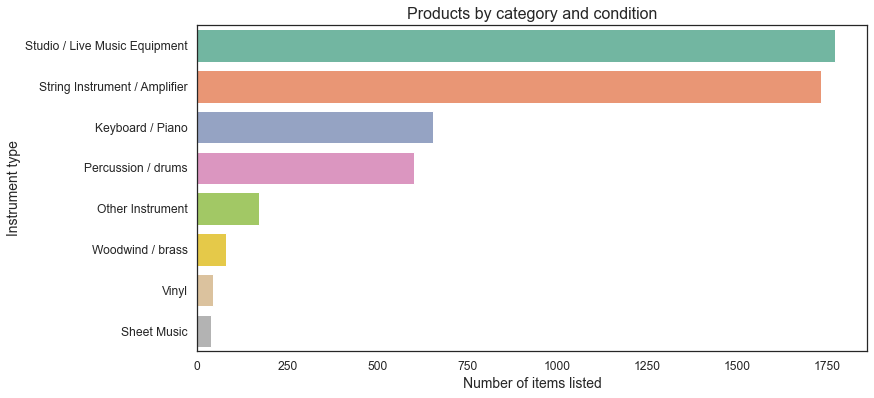

In [4]:
# We are going to make a stacked bar plot to see wich are the most popular categories
# and also the proportion of new and used items in each instrument type.
data = table["Items"].sort_values(["Total"], ascending=False)

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(orient="h", y=data.index, x="Total", data=data)
#add overall title
plt.title("Products by category and condition", fontsize=16)

#add axis titles
plt.xlabel('Number of items listed', fontsize=14)
plt.ylabel('Instrument type', fontsize=14)


From this bar chart we can get a broad picture of how the musical instruments market of Sri Lanka is composed (based on this sample). We can see that the most popular items are in the Studio/Live Equipment category, followed closely by String Instruments. We can appreciate also that there are more used items than new ones in almost all instrument types, the only exception being Sheet Music. 

<AxesSubplot:xlabel='Price_value', ylabel='Instrument_Type'>

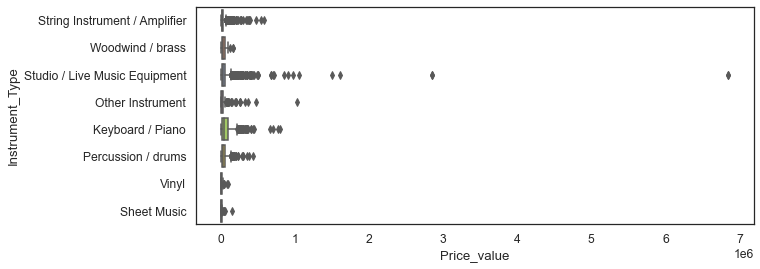

In [5]:
#GRAPH: Bar plot that shows de 10 most popular items, grouped by instrument
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
title = "10 Most popular musical instruments on sell"
sns.boxplot(y="Instrument_Type", x="Price_value", orient="h", ax=ax, data=df.sort_values(["Price_value"]))

We se that are some very expensive items in the Studio/Live Music equipment category. By the name of the category, it sounds logical it could contain some very expensive products. Nevertheless, now we want to get a broad picture of pices distribution in the market so, for now, we are going to discard de 10% most expensive items

<AxesSubplot:xlabel='Price_value', ylabel='Instrument_Type'>

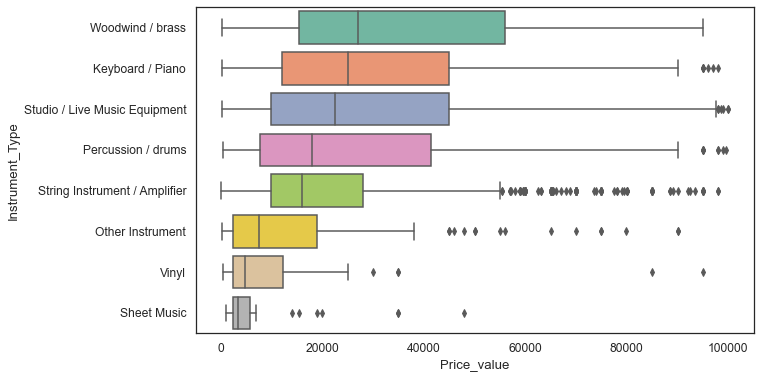

In [6]:
#We set a limit percentile, and we will only take values under that
limit_percentile = 90
limit_price = np.percentile(list(df["Price_value"]), limit_percentile)

# Data to be plotted is stored in an aux dataframe in order to sort categories by mean when plotting
df_bp = df[["Instrument_Type", "Price_value","Condition"]]
df_bp = df_bp[df["Price_value"] < limit_price]
df_means = df_bp.groupby(["Instrument_Type"]).agg({'Price_value': np.mean}).reset_index()
df_means.rename(columns={"Price_value":"Mean Price"}, inplace=True)
df_bp = pd.merge(df_bp, df_means, on="Instrument_Type")

#Box Plot
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y="Instrument_Type", x="Price_value", orient="h", ax=ax, data=df_bp.sort_values(["Mean Price"], ascending=False))

In [7]:
#
def showWordCloud(text):
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=120).generate(text)
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()
    
allTitles = "".join(titles for titles in df["Title"][df.Instrument_Type == "Studio/Live Music Equipment"])

showWordCloud(allTitles)

ValueError: We need at least 1 word to plot a word cloud, got 0.

The origin of the dispersion of prices within instrument types is most likely due to the fact that each category encompasses not only the instruments themselves but also parts, accesories and related products. That effect is most noticeable in the Studio/Live Music Equipment category, wich contains a wide range of very different products.<br>
Let's take a deeper look.

### Used vs New

Previous analysis focused on products categories as a whole. We know that the dataset contains both new and used products. In the folowing section, we are going to see how this classification affects prices and availability.

In [ ]:
# We are going to make a stacked bar plot to see wich are the most popular categories
# and also the proportion of new and used items in each instrument type.

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

table["Items"].sort_values(["Total"]).drop(["Total","% New", "% of Total"], axis=1).plot(kind='barh', stacked=True, ax=ax)
#add overall title
plt.title("How is the instruments market composed?\n\n\nProducts by category and condition", fontsize=16)

#add axis titles
plt.xlabel('Number of items listed', fontsize=14)
plt.ylabel('Instrument type', fontsize=14)


In [ ]:
#Box Plot
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(y="Instrument_Type", x="Price_value", hue="Condition", orient="h", ax=ax, data=df_bp.sort_values(["Mean Price"], ascending=False))

This is very surprising, we see that, except for vinyl, used products are more expensive thant new ones! Let's compare the mean price of new products vs used ones

In [ ]:
df[["Condition", "Price_value"]].groupby(["Condition"]).agg({"Price_value":np.mean}).rename(columns={"Price_value":"Mean Price"})

### Most popular instruments and brands

In [ ]:
# We are going to make a table to count how many instruments of each brand we have
ins_table = df[["Instrument_Type", "Product", "Brand","Title", "Price_value"]].groupby(["Instrument_Type", "Product", "Brand"]).agg({'Title':"count","Price_value":np.mean}).rename(columns={"Title":"Items","Price_value":"Mean Price"}).reset_index().sort_values(["Instrument_Type","Product","Brand"])

In [ ]:
ins_table.sort_values(["Items"], ascending=False).head(10).style.set_caption("10 MOST POPULAR MUSICAL INSTRUMENTS")

In [ ]:
#GRAPH: Bar plot that shows de 10 most popular items, grouped by instrument
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
title = "10 Most popular musical instruments on sell"
sns.barplot(x = "Product", y = "Items", hue = "Brand", ax=ax, data = ins_table.sort_values(["Items"], ascending=False).head(10)).set_title(title, fontsize=16)
#add overall title
#place legend in center right of plot
plt.legend(loc='center right', title='Brand')


As we can appreciate, the most popular items are Yamaha guitars, followed by Keyboards from Yamaha as well, but also from other well known brands. 

In [ ]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
pd.DataFrame(df["Brand"].value_counts()).head(10).sort_values(["Brand"]).plot(kind="barh", ax=ax)

# Graph titles
plt.title("Top 10 Selling brands", fontsize=16)
plt.xlabel('Items listed', fontsize=14)
plt.ylabel('Brand', fontsize=14)

Yamaha is crearly the most important brand in this market, partly due to the wide variety of products they make. Let's take a look at al the Yamaha products.

In [ ]:
# Let's see the products that yamaha manufactures
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
df[df["Brand"] == "Yamaha"]["Product"].value_counts(ascending=True).plot(kind="barh", color="#ed7d4a")

# Graph titles
plt.title("Products by Yamaha", fontsize=16)
plt.xlabel('Items listed', fontsize=14)
plt.ylabel('Product', fontsize=14)

### Most Expensive Products

In [ ]:
ins_table.sort_values(["Mean Price"], ascending=False).head(10).style.set_caption("10 MOST EXPENSIVE MUSICAL INSTRUMENTS")

In [ ]:
#GRAPH: Bar plot that shows de 10 most popular items, grouped by instrument
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
title = "10 Most expensive musical instruments on sell"
sns.barplot(x = "Product", y = "Mean Price", hue = "Brand", ax=ax, data = ins_table.sort_values(["Mean Price"], ascending=False).head(10)).set_title(title, fontsize=16)
#add overall title
#place legend in center right of plot
plt.legend(loc='upper right', title='Brand')


### Geographical análisis